In [115]:
import sys, os, re

sys.path = (["../../src/", "../../"] if re.match(r"^(\w\:\\)|(/)", os.getcwd()) else []) + sys.path

import pandas as pd
import qubx

%qubxd

%load_ext autoreload
%autoreload 2

from qubx import lookup, logger
from qubx.core.interfaces import TriggerEvent, PositionsTracker, IStrategyContext, IStrategy
from qubx.core.basics import DataType, Signal
from qubx.ta.indicators import sma


# - - - - - - - - - - - - - - - - - - - - - - - -
from qubx.trackers.riskctrl import AtrRiskTracker, StopTakePositionTracker
from qubx.trackers.sizers import FixedSizer, FixedRiskSizer, FixedLeverageSizer
from qubx.trackers.composite import CompositeTrackerPerSide
from qubx.data.readers import CsvStorageDataReader, AsPandasFrame
from qubx.data.helpers import loader

from qubx.backtester.simulator import simulate
from qubx.core.metrics import tearsheet, chart_signals

# - - - - - - - - - - - - - - - - - - - - - - - -
from tests.qubx.trackers.trackers_gathering_test import GuineaPig

# - - - - - - - - - - - - - - - - - - - - - - - -
I = lookup.find_symbol("BINANCE.UM", "BTCUSDT")  # noqa: E741

r = CsvStorageDataReader(this_project_root() / "tests/data/csv_1h") # type: ignore  # noqa: F821
r1 = CsvStorageDataReader(this_project_root() / "tests/data/csv")   # type: ignore  # noqa: F821

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Strats to test

In [149]:
class ComplexCompositeTest(GuineaPig):
    def tracker(self, ctx: IStrategyContext) -> PositionsTracker:
        sizer, timeframe = FixedLeverageSizer(1.0), "1h"
        return CompositeTrackerPerSide(
            long_trackers=[
                AtrRiskTracker(
                    take_target=5, stop_risk=3, atr_timeframe=timeframe, atr_period=5, sizer=sizer, risk_controlling_side="broker",
                ),
                StopTakePositionTracker(stop_risk=11, sizer=sizer),
            ],
            short_trackers=[
                AtrRiskTracker(
                    take_target=5, stop_risk=3, atr_timeframe=timeframe, atr_period=5, sizer=sizer, risk_controlling_side="broker",
                ),
                StopTakePositionTracker(stop_risk=11, sizer=sizer),
            ],
        )

class StrategyForTracking(IStrategy):
    timeframe: str = "1Min"
    fast_period = 5
    slow_period = 12
    high_low_risk = True

    def on_init(self, ctx: IStrategyContext) -> None:
        ctx.set_base_subscription(DataType.OHLC[self.timeframe])
        self._n_sig = 0

    def on_event(self, ctx: IStrategyContext, event: TriggerEvent) -> list[Signal] | None:
        signals = []
        for i in ctx.instruments:
            ohlc = ctx.ohlc(i, self.timeframe)
            fast = sma(ohlc.close, self.fast_period)
            slow = sma(ohlc.close, self.slow_period)
            pos = ctx.positions[i].quantity

            if pos <= 0 and (fast[0] > slow[0]) and (fast[1] < slow[1]):
                if self.high_low_risk:
                    signals.append(i.signal(+1, stop=min(ohlc[0].low, ohlc[1].low)))
                else:
                    signals.append(i.signal(+1))

            if pos >= 0 and (fast[0] < slow[0]) and (fast[1] > slow[1]):
                if self.high_low_risk:
                    signals.append(i.signal(-1, stop=max(ohlc[0].high, ohlc[1].high)))
                else:
                    signals.append(i.signal(-1))

        return signals

    def tracker(self, ctx: IStrategyContext) -> PositionsTracker:
        return PositionsTracker(FixedRiskSizer(1, 10_000, reinvest_profit=True))

# Broker side composite test

In [159]:
assert I is not None

rep_c = simulate(
    strategies={
        "Composited": (
            strategy := ComplexCompositeTest(
                tests={
                    "2023-07-05 00:00:00": I.signal(-1),
                    "2023-07-10 00:00:00": I.signal(+1),
                }
            ))}, data={"ohlc(1h)": r}, capital=10000, instruments=["BINANCE.UM:BTCUSDT"], commissions="vip0_usdt", debug="DEBUG",
    start="2023-07-01", stop="2023-08-01",
)
# tearsheet(rep_c)

2024-01-03 14:00:55.000 [🐞] ComplexCompositeTest new parameters:
	set tests <- {'2023-07-05 00:00:00': Signal(instrument=BINANCE.UM:FUTURE:BTCUSDT, signal=-1, price=None, stop=None, take=None, reference_price=None, group='', comment='', options={}), '2023-07-10 00:00:00': Signal(instrument=BINANCE.UM:FUTURE:BTCUSDT, signal=1, price=None, stop=None, take=None, reference_price=None, group='', comment='', options={})}


2023-07-01 00:00:00.000 [🐞] [simulator] :: Preparing simulated trading on BINANCE.UM for 10000 USDT...


Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

2023-07-01 00:00:00.000 [ℹ️] SimulatedDataProvider.binance.um is initialized
2023-07-01 00:00:00.000 [🐞] [simulator] :: Setting default schedule: 0 */1 * * *
2023-07-01 00:00:00.000 [ℹ️] SimulatedDataProvider ::: Simulation started at 2023-07-01 00:00:00 :::
2023-07-01 00:00:00.000 [🐞]   [IteratedDataStreamsSlicer] :: Preloading initial data for ohlc.1Min 2023-07-01 00:00:00 : 2023-08-01 00:00:00 ...
2023-07-01 00:00:05.000 [🐞] [ProcessingManager] :: Invoking ComplexCompositeTest on_fit
2023-07-01 00:00:05.000 [🐞] [ProcessingManager] :: ComplexCompositeTest is fitted
2023-07-05 00:00:00.000 [ℹ️]  - - - |  -1.000000 BINANCE.UM:FUTURE:BTCUSDT | - - - 
2023-07-05 00:00:00.000 [🐞] [AtrRiskTracker.BrokerSideRiskController(BINANCE.UM:FUTURE:BTCUSDT)] :: Processing signal (0) to target: Target +0.000000 for ComplexCompositeTest 30756.10 +0.000000 BINANCE.UM:FUTURE:BTCUSDT (Closing opposite signal -1 )
2023-07-05 00:00:00.000 [🐞] [StopTakePositionTracker.BrokerSideRiskController(BINANCE.UM:FUT

In [ ]:
tearsheet(rep_c)

In [165]:
abs(rep_c[0].signals_log.iloc[0].stop - rep_c[0].executions_log.iloc[1].price) < I.tick_size

True

In [162]:
rep_c[0].executions_log

,instrument_id,exchange_id,side,filled_qty,price,commissions,commissions_quoted,order_id
timestamp,,,,,,,,
2023-07-05 00:00:00,BTCUSDT,BINANCE.UM,sell,-0.325,30756.05,4.997858,USDT,SIM-ORDER-BTCUSDT-100001
2023-07-06 08:36:00,BTCUSDT,BINANCE.UM,buy,0.325,31170.50,5.065206,USDT,SIM-ORDER-BTCUSDT-100003
2023-07-10 00:00:00,BTCUSDT,BINANCE.UM,buy,0.326,30147.85,4.914100,USDT,SIM-ORDER-BTCUSDT-100005
2023-07-10 19:36:00,BTCUSDT,BINANCE.UM,sell,-0.326,30648.40,1.998276,USDT,SIM-ORDER-BTCUSDT-100006


In [ ]:
data1h = r.read("BINANCE.UM:BTCUSDT", "2023-07-01", "2023-08-01", AsPandasFrame())
chart_signals(rep_c[0], I.symbol, data1h, '1h', show_signals=True, height=500, info=True, show_leverage=False)

# ATR tracker test

In [ ]:
rep_atr = simulate(
    strategies={
        "Strategy ST client  (0)": [
            StrategyForTracking(timeframe="15Min", fast_period=10, slow_period=25, high_low_risk=True),
            t0 := StopTakePositionTracker(
                None, None, sizer=FixedRiskSizer(1, 10_000), risk_controlling_side="client"
            ),
        ],
        "Strategy ST broker  (1)": [
            StrategyForTracking(timeframe="15Min", fast_period=10, slow_period=25, high_low_risk=True),
            t1 := StopTakePositionTracker(
                None, None, sizer=FixedRiskSizer(1, 10_000), risk_controlling_side="broker"
            ),
        ],
        "Strategy ATR client (2)": [
            StrategyForTracking(timeframe="15Min", fast_period=10, slow_period=25, high_low_risk=False),
            t2 := AtrRiskTracker(
                5, 5, "15Min", 25, atr_smoother="sma", sizer=FixedRiskSizer(1, 10_000), 
                risk_controlling_side="client",
            ),
        ],
        "Strategy ATR broker (3)": [
            StrategyForTracking(timeframe="15Min", fast_period=10, slow_period=25, high_low_risk=False),
            t3 := AtrRiskTracker(
                5, 5, "15Min", 25, atr_smoother="sma", sizer=FixedRiskSizer(1, 10_000), 
                risk_controlling_side="broker",
            ),
        ],
    }, data={"ohlc": r1, "quote": r1}, capital=10000, instruments=[I], commissions="vip0_usdt", accurate_stop_orders_execution=True,
    debug="DEBUG",
    start="2024-01-01", stop="2024-01-03 14:00",
    # start="2024-01-01", stop="2024-01-02 14:00",
)

In [ ]:
rep_atr[2].executions_log

In [ ]:
rep_atr[3].executions_log

,,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
id,,,,,,,,,,,,,,,
1,Strategy ST broker (1),260.863369,21.946075,10.578861,-0.010267,4.881127,523.698000,267.614180,16946.930371,21.854599,0.711481,124.041865,0.870205,154.764131,27.0
0,Strategy ST client (0),137.427120,4.262704,6.958802,-0.238009,4.937937,523.698000,47.212418,1306.478587,5.427333,0.599930,123.960546,0.461305,164.720480,30.0
3,Strategy ATR broker (3),-197.064234,-0.911216,-10.465948,-0.746084,3.419145,343.747283,-13.444780,-51.831101,0.284884,0.412226,226.574624,-0.656434,73.084384,14.0
2,Strategy ATR client (2),-209.314888,-0.923747,-10.930867,-0.825157,3.619242,363.864218,-13.795519,-51.440003,0.270566,0.423288,233.529871,-0.697661,74.635888,14.0


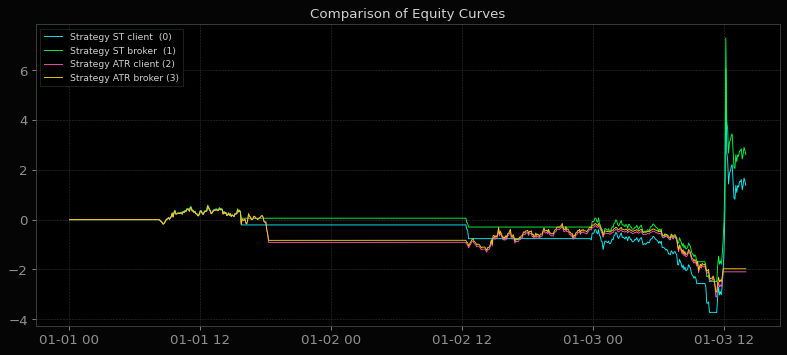

In [154]:
tearsheet(rep_atr)
# scols(rep_atr[0].executions_log, rep_atr[1].executions_log, keys=["Client", "Broker"])

In [68]:
data1m = r1.read("BINANCE.UM:BTCUSDT", "2024-01-01", "2024-01-03 14:00", AsPandasFrame())

In [ ]:
chart_signals(rep_atr[1], I.symbol, data1m, '15Min', show_signals=True, height=500, info=True, show_leverage=False)